# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!python --version

Python 2.7.12


In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

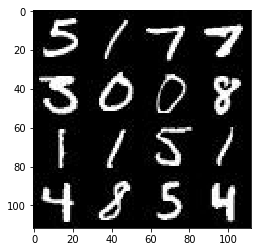

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

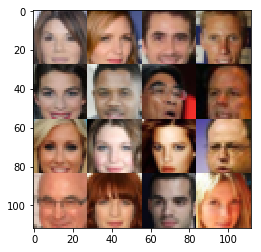

In [4]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, 
                                shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_input")
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate', shape=())
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.6):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function    
    def convnet(input_, filter_, padding_='same', batch_norm=True):
        conv = tf.layers.conv2d(input_, filter_, 5, strides=2, padding=padding_,
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                use_bias=False)
        if batch_norm:
            conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(conv * alpha, conv)
        return tf.nn.dropout(conv, keep_prob=keep_prob)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = convnet(images, 64, batch_norm=False)
        conv2 = convnet(conv1, 128)
        conv3 = convnet(conv2, 256)
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.2, keep_prob=0.6):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    def conv_transpose(input_, filter_, s=2):
        conv = tf.layers.conv2d_transpose(input_, filter_, 5, strides=s, padding='SAME', 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                              use_bias=False)
            
        conv = tf.layers.batch_normalization(conv, training=is_train)
        return tf.maximum(conv * alpha, conv)
    
    with tf.variable_scope('generator', reuse=not is_train):
        fc = tf.layers.dense(z, 7*7*1024)
        fc = tf.reshape(fc, (-1, 7, 7, 1024))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        fc = tf.nn.dropout(tf.maximum(fc * alpha, fc), keep_prob=keep_prob)
        
        conv1 = conv_transpose(fc, 512) # shape 14*14*512
        conv2 = conv_transpose(conv1, 256, s=1) # shape 14*14*256
        conv3 = conv_transpose(conv2, 128, s=1) # 14*14*128
        conv4 = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='SAME',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                           use_bias=False)
    return tf.tanh(conv4)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim=out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) # *data_shape
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # rescale to be in [-1,1] for D
#                 print(batch_images[:10])
                batch_images = batch_images * 2
        
                # Noise for G
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               lr: learning_rate})
                
                if steps % 25 == 0:      
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} . step {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 150 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
            # Generate at end of epoch 
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

('Epoch 1/2 . step 25...', 'Discriminator Loss: 2.4558...', 'Generator Loss: 1.7182')
('Epoch 1/2 . step 50...', 'Discriminator Loss: 1.3348...', 'Generator Loss: 1.2733')
('Epoch 1/2 . step 75...', 'Discriminator Loss: 1.6101...', 'Generator Loss: 1.4541')
('Epoch 1/2 . step 100...', 'Discriminator Loss: 1.3473...', 'Generator Loss: 1.1844')
('Epoch 1/2 . step 125...', 'Discriminator Loss: 1.4459...', 'Generator Loss: 1.7198')
('Epoch 1/2 . step 150...', 'Discriminator Loss: 1.4187...', 'Generator Loss: 0.9370')


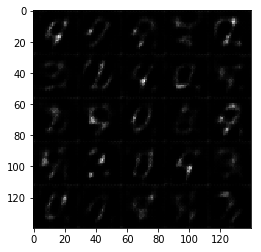

('Epoch 1/2 . step 175...', 'Discriminator Loss: 1.5278...', 'Generator Loss: 0.7279')
('Epoch 1/2 . step 200...', 'Discriminator Loss: 1.5302...', 'Generator Loss: 0.8398')
('Epoch 1/2 . step 225...', 'Discriminator Loss: 1.5655...', 'Generator Loss: 0.8320')
('Epoch 1/2 . step 250...', 'Discriminator Loss: 1.3119...', 'Generator Loss: 1.2856')
('Epoch 1/2 . step 275...', 'Discriminator Loss: 1.3740...', 'Generator Loss: 0.9811')
('Epoch 1/2 . step 300...', 'Discriminator Loss: 1.4707...', 'Generator Loss: 0.8604')


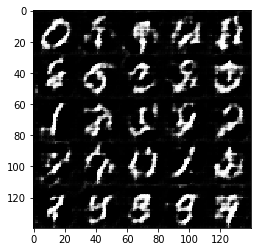

('Epoch 1/2 . step 325...', 'Discriminator Loss: 1.3251...', 'Generator Loss: 0.9483')
('Epoch 1/2 . step 350...', 'Discriminator Loss: 1.4056...', 'Generator Loss: 0.8740')
('Epoch 1/2 . step 375...', 'Discriminator Loss: 1.2571...', 'Generator Loss: 0.7807')
('Epoch 1/2 . step 400...', 'Discriminator Loss: 1.3871...', 'Generator Loss: 0.8530')
('Epoch 1/2 . step 425...', 'Discriminator Loss: 1.4446...', 'Generator Loss: 0.9021')
('Epoch 1/2 . step 450...', 'Discriminator Loss: 1.2791...', 'Generator Loss: 1.0949')


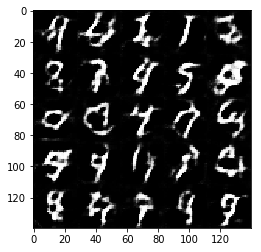

('Epoch 1/2 . step 475...', 'Discriminator Loss: 1.3236...', 'Generator Loss: 1.0193')
('Epoch 1/2 . step 500...', 'Discriminator Loss: 1.3249...', 'Generator Loss: 0.7870')
('Epoch 1/2 . step 525...', 'Discriminator Loss: 1.3216...', 'Generator Loss: 0.7065')
('Epoch 1/2 . step 550...', 'Discriminator Loss: 1.3597...', 'Generator Loss: 1.1405')
('Epoch 1/2 . step 575...', 'Discriminator Loss: 1.3796...', 'Generator Loss: 0.6378')
('Epoch 1/2 . step 600...', 'Discriminator Loss: 1.3388...', 'Generator Loss: 0.8125')


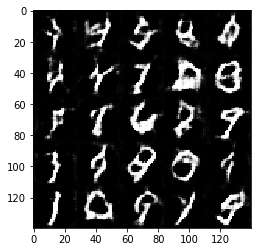

('Epoch 1/2 . step 625...', 'Discriminator Loss: 1.3380...', 'Generator Loss: 0.8472')
('Epoch 1/2 . step 650...', 'Discriminator Loss: 1.3095...', 'Generator Loss: 0.9645')
('Epoch 1/2 . step 675...', 'Discriminator Loss: 1.2131...', 'Generator Loss: 0.9409')
('Epoch 1/2 . step 700...', 'Discriminator Loss: 1.2702...', 'Generator Loss: 0.7437')
('Epoch 1/2 . step 725...', 'Discriminator Loss: 1.3521...', 'Generator Loss: 0.9024')
('Epoch 1/2 . step 750...', 'Discriminator Loss: 1.2964...', 'Generator Loss: 0.9726')


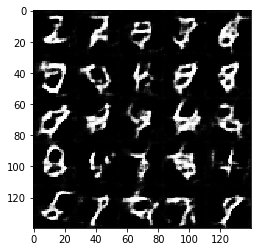

('Epoch 1/2 . step 775...', 'Discriminator Loss: 1.2724...', 'Generator Loss: 0.9574')
('Epoch 1/2 . step 800...', 'Discriminator Loss: 1.3518...', 'Generator Loss: 1.0333')
('Epoch 1/2 . step 825...', 'Discriminator Loss: 1.4353...', 'Generator Loss: 0.8025')
('Epoch 1/2 . step 850...', 'Discriminator Loss: 1.3478...', 'Generator Loss: 1.0188')
('Epoch 1/2 . step 875...', 'Discriminator Loss: 1.4013...', 'Generator Loss: 0.8166')
('Epoch 1/2 . step 900...', 'Discriminator Loss: 1.3574...', 'Generator Loss: 0.9196')


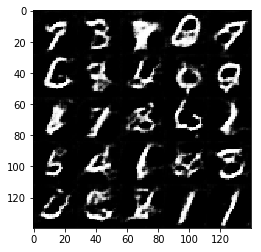

('Epoch 1/2 . step 925...', 'Discriminator Loss: 1.3574...', 'Generator Loss: 0.8417')


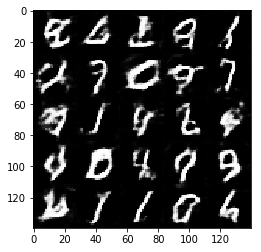

('Epoch 2/2 . step 950...', 'Discriminator Loss: 1.3972...', 'Generator Loss: 0.8846')
('Epoch 2/2 . step 975...', 'Discriminator Loss: 1.3786...', 'Generator Loss: 1.0974')
('Epoch 2/2 . step 1000...', 'Discriminator Loss: 1.4208...', 'Generator Loss: 0.7775')
('Epoch 2/2 . step 1025...', 'Discriminator Loss: 1.3014...', 'Generator Loss: 0.7050')
('Epoch 2/2 . step 1050...', 'Discriminator Loss: 1.3551...', 'Generator Loss: 0.7653')


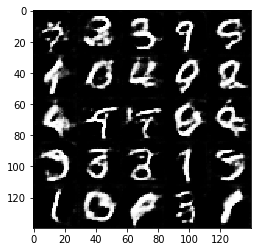

('Epoch 2/2 . step 1075...', 'Discriminator Loss: 1.3159...', 'Generator Loss: 1.0521')
('Epoch 2/2 . step 1100...', 'Discriminator Loss: 1.2301...', 'Generator Loss: 0.9180')
('Epoch 2/2 . step 1125...', 'Discriminator Loss: 1.4311...', 'Generator Loss: 0.7961')
('Epoch 2/2 . step 1150...', 'Discriminator Loss: 1.3815...', 'Generator Loss: 0.8885')
('Epoch 2/2 . step 1175...', 'Discriminator Loss: 1.2467...', 'Generator Loss: 1.0250')
('Epoch 2/2 . step 1200...', 'Discriminator Loss: 1.2627...', 'Generator Loss: 0.9225')


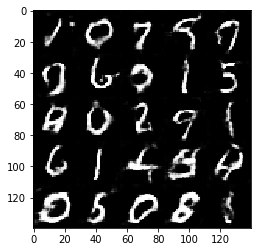

('Epoch 2/2 . step 1225...', 'Discriminator Loss: 1.4231...', 'Generator Loss: 0.7314')
('Epoch 2/2 . step 1250...', 'Discriminator Loss: 1.2103...', 'Generator Loss: 0.9390')
('Epoch 2/2 . step 1275...', 'Discriminator Loss: 1.4237...', 'Generator Loss: 1.1038')
('Epoch 2/2 . step 1300...', 'Discriminator Loss: 1.3253...', 'Generator Loss: 0.9325')
('Epoch 2/2 . step 1325...', 'Discriminator Loss: 1.3467...', 'Generator Loss: 0.8170')
('Epoch 2/2 . step 1350...', 'Discriminator Loss: 1.3505...', 'Generator Loss: 1.0813')


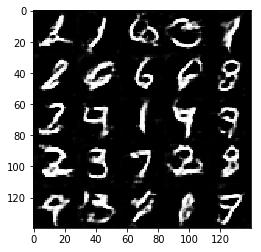

('Epoch 2/2 . step 1375...', 'Discriminator Loss: 1.2796...', 'Generator Loss: 0.9195')
('Epoch 2/2 . step 1400...', 'Discriminator Loss: 1.3937...', 'Generator Loss: 0.7767')
('Epoch 2/2 . step 1425...', 'Discriminator Loss: 1.3889...', 'Generator Loss: 0.8020')
('Epoch 2/2 . step 1450...', 'Discriminator Loss: 1.2606...', 'Generator Loss: 0.8721')
('Epoch 2/2 . step 1475...', 'Discriminator Loss: 1.4672...', 'Generator Loss: 0.7271')
('Epoch 2/2 . step 1500...', 'Discriminator Loss: 1.4144...', 'Generator Loss: 1.0465')


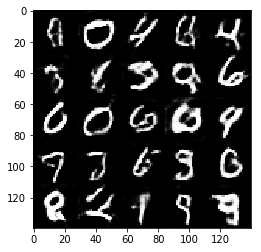

('Epoch 2/2 . step 1525...', 'Discriminator Loss: 1.3684...', 'Generator Loss: 1.0051')
('Epoch 2/2 . step 1550...', 'Discriminator Loss: 1.2472...', 'Generator Loss: 1.0000')
('Epoch 2/2 . step 1575...', 'Discriminator Loss: 1.3745...', 'Generator Loss: 0.9651')
('Epoch 2/2 . step 1600...', 'Discriminator Loss: 1.3563...', 'Generator Loss: 0.7813')
('Epoch 2/2 . step 1625...', 'Discriminator Loss: 1.2875...', 'Generator Loss: 0.8852')
('Epoch 2/2 . step 1650...', 'Discriminator Loss: 1.4284...', 'Generator Loss: 1.0956')


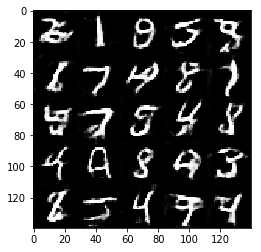

('Epoch 2/2 . step 1675...', 'Discriminator Loss: 1.3416...', 'Generator Loss: 0.8171')
('Epoch 2/2 . step 1700...', 'Discriminator Loss: 1.3238...', 'Generator Loss: 0.9759')
('Epoch 2/2 . step 1725...', 'Discriminator Loss: 1.3016...', 'Generator Loss: 0.9585')
('Epoch 2/2 . step 1750...', 'Discriminator Loss: 1.3290...', 'Generator Loss: 0.9892')
('Epoch 2/2 . step 1775...', 'Discriminator Loss: 1.3572...', 'Generator Loss: 0.9521')
('Epoch 2/2 . step 1800...', 'Discriminator Loss: 1.2666...', 'Generator Loss: 0.8523')


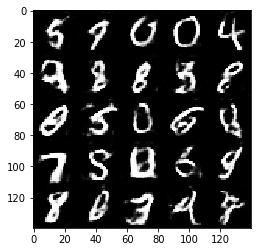

('Epoch 2/2 . step 1825...', 'Discriminator Loss: 1.4170...', 'Generator Loss: 0.7928')
('Epoch 2/2 . step 1850...', 'Discriminator Loss: 1.3720...', 'Generator Loss: 0.9821')


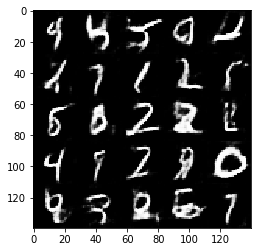

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

('Epoch 1/2 . step 25...', 'Discriminator Loss: 2.2293...', 'Generator Loss: 1.3156')
('Epoch 1/2 . step 50...', 'Discriminator Loss: 1.4879...', 'Generator Loss: 1.1722')
('Epoch 1/2 . step 75...', 'Discriminator Loss: 1.6697...', 'Generator Loss: 1.0040')
('Epoch 1/2 . step 100...', 'Discriminator Loss: 1.5560...', 'Generator Loss: 0.7973')
('Epoch 1/2 . step 125...', 'Discriminator Loss: 1.6121...', 'Generator Loss: 0.7398')
('Epoch 1/2 . step 150...', 'Discriminator Loss: 1.5251...', 'Generator Loss: 0.7693')


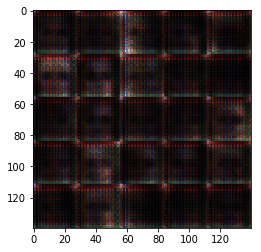

('Epoch 1/2 . step 175...', 'Discriminator Loss: 1.5347...', 'Generator Loss: 0.8640')
('Epoch 1/2 . step 200...', 'Discriminator Loss: 1.5323...', 'Generator Loss: 0.7699')
('Epoch 1/2 . step 225...', 'Discriminator Loss: 1.5085...', 'Generator Loss: 0.8905')
('Epoch 1/2 . step 250...', 'Discriminator Loss: 1.5431...', 'Generator Loss: 0.9317')
('Epoch 1/2 . step 275...', 'Discriminator Loss: 1.5286...', 'Generator Loss: 0.9226')
('Epoch 1/2 . step 300...', 'Discriminator Loss: 1.3002...', 'Generator Loss: 0.8604')


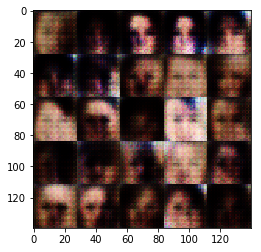

('Epoch 1/2 . step 325...', 'Discriminator Loss: 1.3796...', 'Generator Loss: 0.9178')
('Epoch 1/2 . step 350...', 'Discriminator Loss: 1.4912...', 'Generator Loss: 1.0727')
('Epoch 1/2 . step 375...', 'Discriminator Loss: 1.4837...', 'Generator Loss: 0.8513')
('Epoch 1/2 . step 400...', 'Discriminator Loss: 1.4259...', 'Generator Loss: 0.6532')
('Epoch 1/2 . step 425...', 'Discriminator Loss: 1.1986...', 'Generator Loss: 1.0158')
('Epoch 1/2 . step 450...', 'Discriminator Loss: 1.4187...', 'Generator Loss: 0.9936')


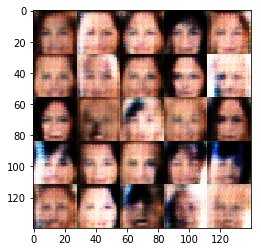

('Epoch 1/2 . step 475...', 'Discriminator Loss: 1.3398...', 'Generator Loss: 1.1256')
('Epoch 1/2 . step 500...', 'Discriminator Loss: 1.4178...', 'Generator Loss: 0.9436')
('Epoch 1/2 . step 525...', 'Discriminator Loss: 1.3851...', 'Generator Loss: 0.7983')
('Epoch 1/2 . step 550...', 'Discriminator Loss: 1.4127...', 'Generator Loss: 0.7242')
('Epoch 1/2 . step 575...', 'Discriminator Loss: 1.4680...', 'Generator Loss: 0.6806')
('Epoch 1/2 . step 600...', 'Discriminator Loss: 1.4505...', 'Generator Loss: 0.5891')


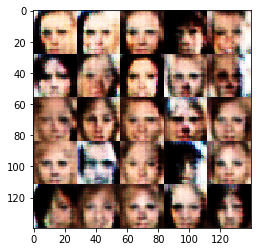

('Epoch 1/2 . step 625...', 'Discriminator Loss: 1.4306...', 'Generator Loss: 1.2074')
('Epoch 1/2 . step 650...', 'Discriminator Loss: 1.4201...', 'Generator Loss: 0.9775')
('Epoch 1/2 . step 675...', 'Discriminator Loss: 1.2675...', 'Generator Loss: 0.8815')
('Epoch 1/2 . step 700...', 'Discriminator Loss: 1.4738...', 'Generator Loss: 0.8117')
('Epoch 1/2 . step 725...', 'Discriminator Loss: 1.3143...', 'Generator Loss: 0.9173')
('Epoch 1/2 . step 750...', 'Discriminator Loss: 1.3692...', 'Generator Loss: 0.8693')


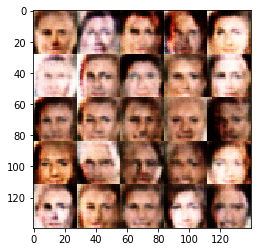

('Epoch 1/2 . step 775...', 'Discriminator Loss: 1.4886...', 'Generator Loss: 0.8554')
('Epoch 1/2 . step 800...', 'Discriminator Loss: 1.3868...', 'Generator Loss: 0.7059')
('Epoch 1/2 . step 825...', 'Discriminator Loss: 1.4267...', 'Generator Loss: 0.8417')
('Epoch 1/2 . step 850...', 'Discriminator Loss: 1.5025...', 'Generator Loss: 0.7389')
('Epoch 1/2 . step 875...', 'Discriminator Loss: 1.5205...', 'Generator Loss: 0.9747')
('Epoch 1/2 . step 900...', 'Discriminator Loss: 1.2900...', 'Generator Loss: 0.8835')


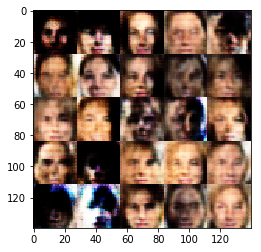

('Epoch 1/2 . step 925...', 'Discriminator Loss: 1.3900...', 'Generator Loss: 0.9293')
('Epoch 1/2 . step 950...', 'Discriminator Loss: 1.3927...', 'Generator Loss: 0.7303')
('Epoch 1/2 . step 975...', 'Discriminator Loss: 1.3468...', 'Generator Loss: 1.0502')
('Epoch 1/2 . step 1000...', 'Discriminator Loss: 1.4172...', 'Generator Loss: 0.9105')
('Epoch 1/2 . step 1025...', 'Discriminator Loss: 1.4010...', 'Generator Loss: 1.0116')
('Epoch 1/2 . step 1050...', 'Discriminator Loss: 1.4083...', 'Generator Loss: 0.8148')


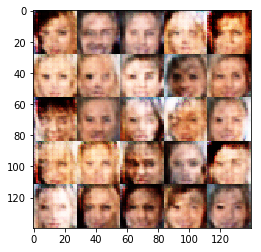

('Epoch 1/2 . step 1075...', 'Discriminator Loss: 1.3744...', 'Generator Loss: 0.7593')
('Epoch 1/2 . step 1100...', 'Discriminator Loss: 1.4074...', 'Generator Loss: 0.7051')
('Epoch 1/2 . step 1125...', 'Discriminator Loss: 1.4187...', 'Generator Loss: 0.7435')
('Epoch 1/2 . step 1150...', 'Discriminator Loss: 1.3276...', 'Generator Loss: 0.8623')
('Epoch 1/2 . step 1175...', 'Discriminator Loss: 1.3712...', 'Generator Loss: 0.8759')
('Epoch 1/2 . step 1200...', 'Discriminator Loss: 1.4155...', 'Generator Loss: 0.7311')


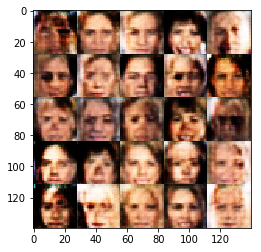

('Epoch 1/2 . step 1225...', 'Discriminator Loss: 1.4877...', 'Generator Loss: 0.8128')
('Epoch 1/2 . step 1250...', 'Discriminator Loss: 1.3983...', 'Generator Loss: 0.7275')
('Epoch 1/2 . step 1275...', 'Discriminator Loss: 1.3485...', 'Generator Loss: 0.8988')
('Epoch 1/2 . step 1300...', 'Discriminator Loss: 1.3789...', 'Generator Loss: 0.6402')
('Epoch 1/2 . step 1325...', 'Discriminator Loss: 1.4268...', 'Generator Loss: 0.8007')
('Epoch 1/2 . step 1350...', 'Discriminator Loss: 1.3683...', 'Generator Loss: 0.8471')


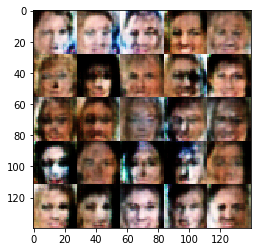

('Epoch 1/2 . step 1375...', 'Discriminator Loss: 1.4001...', 'Generator Loss: 0.8214')
('Epoch 1/2 . step 1400...', 'Discriminator Loss: 1.3629...', 'Generator Loss: 0.6927')
('Epoch 1/2 . step 1425...', 'Discriminator Loss: 1.4430...', 'Generator Loss: 0.7468')
('Epoch 1/2 . step 1450...', 'Discriminator Loss: 1.4231...', 'Generator Loss: 0.7278')
('Epoch 1/2 . step 1475...', 'Discriminator Loss: 1.3871...', 'Generator Loss: 0.9865')
('Epoch 1/2 . step 1500...', 'Discriminator Loss: 1.3972...', 'Generator Loss: 0.8684')


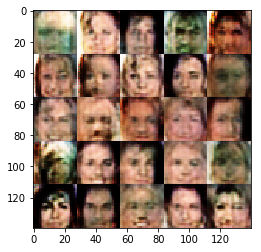

('Epoch 1/2 . step 1525...', 'Discriminator Loss: 1.3240...', 'Generator Loss: 0.9098')
('Epoch 1/2 . step 1550...', 'Discriminator Loss: 1.3391...', 'Generator Loss: 1.1832')
('Epoch 1/2 . step 1575...', 'Discriminator Loss: 1.4104...', 'Generator Loss: 0.7543')
('Epoch 1/2 . step 1600...', 'Discriminator Loss: 1.4560...', 'Generator Loss: 0.9716')
('Epoch 1/2 . step 1625...', 'Discriminator Loss: 1.4119...', 'Generator Loss: 0.8730')
('Epoch 1/2 . step 1650...', 'Discriminator Loss: 1.3236...', 'Generator Loss: 0.8388')


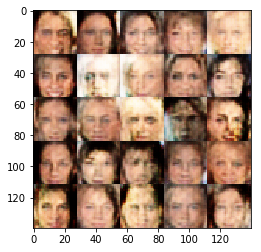

('Epoch 1/2 . step 1675...', 'Discriminator Loss: 1.3815...', 'Generator Loss: 0.8724')
('Epoch 1/2 . step 1700...', 'Discriminator Loss: 1.4146...', 'Generator Loss: 0.6926')
('Epoch 1/2 . step 1725...', 'Discriminator Loss: 1.4379...', 'Generator Loss: 0.8231')
('Epoch 1/2 . step 1750...', 'Discriminator Loss: 1.4057...', 'Generator Loss: 0.8635')
('Epoch 1/2 . step 1775...', 'Discriminator Loss: 1.4609...', 'Generator Loss: 0.6827')
('Epoch 1/2 . step 1800...', 'Discriminator Loss: 1.3894...', 'Generator Loss: 0.9115')


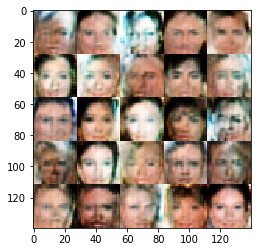

('Epoch 1/2 . step 1825...', 'Discriminator Loss: 1.5767...', 'Generator Loss: 0.8999')
('Epoch 1/2 . step 1850...', 'Discriminator Loss: 1.4084...', 'Generator Loss: 0.7976')
('Epoch 1/2 . step 1875...', 'Discriminator Loss: 1.3803...', 'Generator Loss: 0.6405')
('Epoch 1/2 . step 1900...', 'Discriminator Loss: 1.3895...', 'Generator Loss: 0.7585')
('Epoch 1/2 . step 1925...', 'Discriminator Loss: 1.3140...', 'Generator Loss: 0.8275')
('Epoch 1/2 . step 1950...', 'Discriminator Loss: 1.4289...', 'Generator Loss: 0.8324')


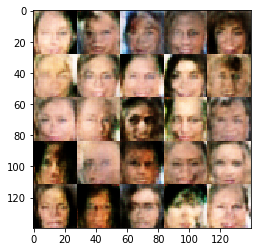

('Epoch 1/2 . step 1975...', 'Discriminator Loss: 1.4361...', 'Generator Loss: 0.7542')
('Epoch 1/2 . step 2000...', 'Discriminator Loss: 1.3849...', 'Generator Loss: 0.8777')
('Epoch 1/2 . step 2025...', 'Discriminator Loss: 1.3752...', 'Generator Loss: 0.8040')
('Epoch 1/2 . step 2050...', 'Discriminator Loss: 1.4010...', 'Generator Loss: 0.7128')
('Epoch 1/2 . step 2075...', 'Discriminator Loss: 1.3942...', 'Generator Loss: 0.9039')
('Epoch 1/2 . step 2100...', 'Discriminator Loss: 1.4760...', 'Generator Loss: 0.5709')


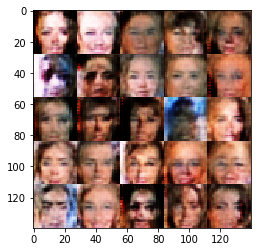

('Epoch 1/2 . step 2125...', 'Discriminator Loss: 1.2871...', 'Generator Loss: 1.2204')
('Epoch 1/2 . step 2150...', 'Discriminator Loss: 1.3486...', 'Generator Loss: 0.7820')
('Epoch 1/2 . step 2175...', 'Discriminator Loss: 1.3814...', 'Generator Loss: 0.7550')
('Epoch 1/2 . step 2200...', 'Discriminator Loss: 1.3576...', 'Generator Loss: 0.8533')
('Epoch 1/2 . step 2225...', 'Discriminator Loss: 1.4429...', 'Generator Loss: 0.7956')
('Epoch 1/2 . step 2250...', 'Discriminator Loss: 1.4547...', 'Generator Loss: 0.7195')


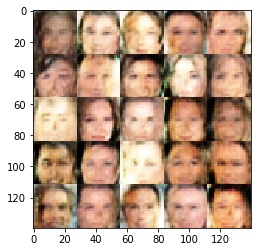

('Epoch 1/2 . step 2275...', 'Discriminator Loss: 1.4340...', 'Generator Loss: 0.8296')
('Epoch 1/2 . step 2300...', 'Discriminator Loss: 1.3526...', 'Generator Loss: 0.7576')
('Epoch 1/2 . step 2325...', 'Discriminator Loss: 1.3550...', 'Generator Loss: 0.7241')
('Epoch 1/2 . step 2350...', 'Discriminator Loss: 1.3638...', 'Generator Loss: 0.8560')
('Epoch 1/2 . step 2375...', 'Discriminator Loss: 1.4552...', 'Generator Loss: 0.6702')
('Epoch 1/2 . step 2400...', 'Discriminator Loss: 1.3750...', 'Generator Loss: 0.8052')


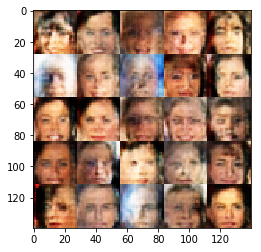

('Epoch 1/2 . step 2425...', 'Discriminator Loss: 1.3187...', 'Generator Loss: 0.8719')
('Epoch 1/2 . step 2450...', 'Discriminator Loss: 1.3877...', 'Generator Loss: 0.8975')
('Epoch 1/2 . step 2475...', 'Discriminator Loss: 1.3879...', 'Generator Loss: 0.7975')
('Epoch 1/2 . step 2500...', 'Discriminator Loss: 1.3861...', 'Generator Loss: 0.8690')
('Epoch 1/2 . step 2525...', 'Discriminator Loss: 1.3596...', 'Generator Loss: 0.8816')
('Epoch 1/2 . step 2550...', 'Discriminator Loss: 1.3590...', 'Generator Loss: 0.8375')


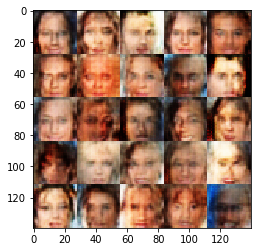

('Epoch 1/2 . step 2575...', 'Discriminator Loss: 1.3636...', 'Generator Loss: 0.8592')
('Epoch 1/2 . step 2600...', 'Discriminator Loss: 1.3419...', 'Generator Loss: 0.8307')
('Epoch 1/2 . step 2625...', 'Discriminator Loss: 1.3906...', 'Generator Loss: 0.7929')
('Epoch 1/2 . step 2650...', 'Discriminator Loss: 1.4246...', 'Generator Loss: 0.8876')
('Epoch 1/2 . step 2675...', 'Discriminator Loss: 1.3452...', 'Generator Loss: 0.9852')
('Epoch 1/2 . step 2700...', 'Discriminator Loss: 1.3776...', 'Generator Loss: 0.8212')


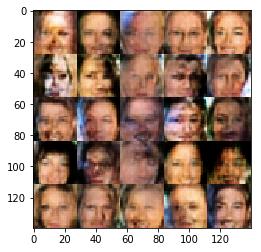

('Epoch 1/2 . step 2725...', 'Discriminator Loss: 1.4126...', 'Generator Loss: 0.8173')
('Epoch 1/2 . step 2750...', 'Discriminator Loss: 1.3446...', 'Generator Loss: 0.8362')
('Epoch 1/2 . step 2775...', 'Discriminator Loss: 1.4134...', 'Generator Loss: 0.8700')
('Epoch 1/2 . step 2800...', 'Discriminator Loss: 1.3914...', 'Generator Loss: 0.7067')
('Epoch 1/2 . step 2825...', 'Discriminator Loss: 1.3959...', 'Generator Loss: 0.7856')
('Epoch 1/2 . step 2850...', 'Discriminator Loss: 1.3702...', 'Generator Loss: 0.8263')


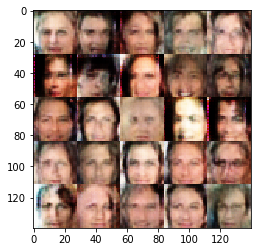

('Epoch 1/2 . step 2875...', 'Discriminator Loss: 1.4478...', 'Generator Loss: 0.7795')
('Epoch 1/2 . step 2900...', 'Discriminator Loss: 1.2863...', 'Generator Loss: 0.9287')
('Epoch 1/2 . step 2925...', 'Discriminator Loss: 1.3681...', 'Generator Loss: 0.8332')
('Epoch 1/2 . step 2950...', 'Discriminator Loss: 1.3953...', 'Generator Loss: 0.7711')
('Epoch 1/2 . step 2975...', 'Discriminator Loss: 1.4058...', 'Generator Loss: 0.7837')
('Epoch 1/2 . step 3000...', 'Discriminator Loss: 1.3780...', 'Generator Loss: 0.8374')


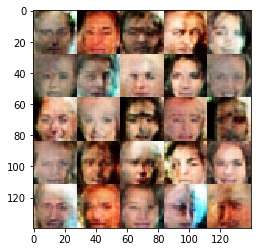

('Epoch 1/2 . step 3025...', 'Discriminator Loss: 1.4133...', 'Generator Loss: 0.8151')
('Epoch 1/2 . step 3050...', 'Discriminator Loss: 1.4081...', 'Generator Loss: 0.8186')
('Epoch 1/2 . step 3075...', 'Discriminator Loss: 1.3610...', 'Generator Loss: 0.8009')
('Epoch 1/2 . step 3100...', 'Discriminator Loss: 1.4170...', 'Generator Loss: 0.8142')
('Epoch 1/2 . step 3125...', 'Discriminator Loss: 1.4249...', 'Generator Loss: 0.7928')
('Epoch 1/2 . step 3150...', 'Discriminator Loss: 1.3866...', 'Generator Loss: 0.8311')


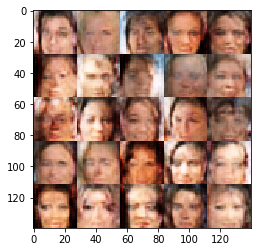

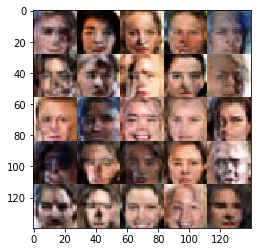

('Epoch 2/2 . step 3175...', 'Discriminator Loss: 1.4059...', 'Generator Loss: 0.7684')
('Epoch 2/2 . step 3200...', 'Discriminator Loss: 1.3808...', 'Generator Loss: 0.7709')
('Epoch 2/2 . step 3225...', 'Discriminator Loss: 1.3683...', 'Generator Loss: 0.7856')
('Epoch 2/2 . step 3250...', 'Discriminator Loss: 1.3744...', 'Generator Loss: 0.7499')
('Epoch 2/2 . step 3275...', 'Discriminator Loss: 1.3739...', 'Generator Loss: 0.8858')
('Epoch 2/2 . step 3300...', 'Discriminator Loss: 1.3241...', 'Generator Loss: 0.8017')


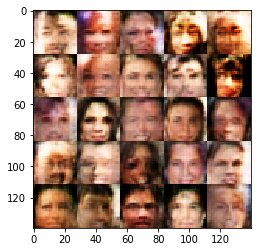

('Epoch 2/2 . step 3325...', 'Discriminator Loss: 1.4545...', 'Generator Loss: 0.7443')
('Epoch 2/2 . step 3350...', 'Discriminator Loss: 1.4120...', 'Generator Loss: 0.8343')
('Epoch 2/2 . step 3375...', 'Discriminator Loss: 1.4261...', 'Generator Loss: 0.7606')
('Epoch 2/2 . step 3400...', 'Discriminator Loss: 1.4043...', 'Generator Loss: 0.7588')
('Epoch 2/2 . step 3425...', 'Discriminator Loss: 1.4049...', 'Generator Loss: 0.7533')
('Epoch 2/2 . step 3450...', 'Discriminator Loss: 1.4238...', 'Generator Loss: 0.7579')


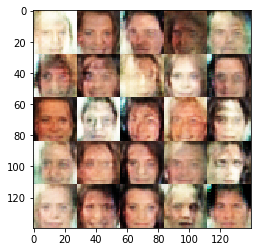

('Epoch 2/2 . step 3475...', 'Discriminator Loss: 1.3852...', 'Generator Loss: 0.7398')
('Epoch 2/2 . step 3500...', 'Discriminator Loss: 1.3467...', 'Generator Loss: 0.8409')
('Epoch 2/2 . step 3525...', 'Discriminator Loss: 1.3520...', 'Generator Loss: 0.8294')
('Epoch 2/2 . step 3550...', 'Discriminator Loss: 1.3776...', 'Generator Loss: 0.7543')
('Epoch 2/2 . step 3575...', 'Discriminator Loss: 1.3601...', 'Generator Loss: 0.8239')
('Epoch 2/2 . step 3600...', 'Discriminator Loss: 1.3971...', 'Generator Loss: 0.8413')


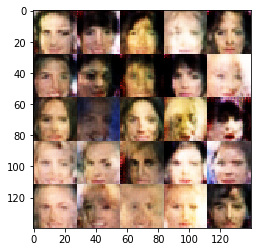

('Epoch 2/2 . step 3625...', 'Discriminator Loss: 1.4083...', 'Generator Loss: 0.7031')
('Epoch 2/2 . step 3650...', 'Discriminator Loss: 1.3093...', 'Generator Loss: 0.9036')
('Epoch 2/2 . step 3675...', 'Discriminator Loss: 1.4053...', 'Generator Loss: 0.7987')
('Epoch 2/2 . step 3700...', 'Discriminator Loss: 1.3814...', 'Generator Loss: 0.7402')
('Epoch 2/2 . step 3725...', 'Discriminator Loss: 1.4348...', 'Generator Loss: 0.7716')
('Epoch 2/2 . step 3750...', 'Discriminator Loss: 1.3817...', 'Generator Loss: 0.8239')


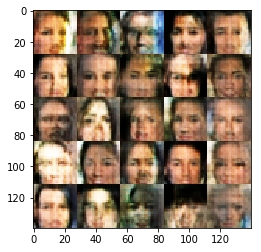

('Epoch 2/2 . step 3775...', 'Discriminator Loss: 1.3735...', 'Generator Loss: 0.8001')
('Epoch 2/2 . step 3800...', 'Discriminator Loss: 1.4089...', 'Generator Loss: 0.8366')
('Epoch 2/2 . step 3825...', 'Discriminator Loss: 1.4465...', 'Generator Loss: 0.7734')
('Epoch 2/2 . step 3850...', 'Discriminator Loss: 1.4103...', 'Generator Loss: 0.7865')
('Epoch 2/2 . step 3875...', 'Discriminator Loss: 1.3814...', 'Generator Loss: 0.8139')
('Epoch 2/2 . step 3900...', 'Discriminator Loss: 1.3794...', 'Generator Loss: 0.7454')


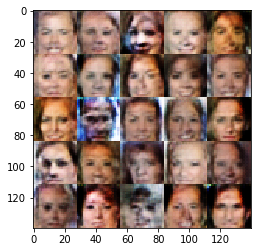

('Epoch 2/2 . step 3925...', 'Discriminator Loss: 1.3965...', 'Generator Loss: 0.8367')
('Epoch 2/2 . step 3950...', 'Discriminator Loss: 1.3997...', 'Generator Loss: 0.8180')
('Epoch 2/2 . step 3975...', 'Discriminator Loss: 1.3869...', 'Generator Loss: 0.7667')
('Epoch 2/2 . step 4000...', 'Discriminator Loss: 1.3978...', 'Generator Loss: 0.7968')
('Epoch 2/2 . step 4025...', 'Discriminator Loss: 1.3928...', 'Generator Loss: 0.9237')
('Epoch 2/2 . step 4050...', 'Discriminator Loss: 1.3605...', 'Generator Loss: 0.7846')


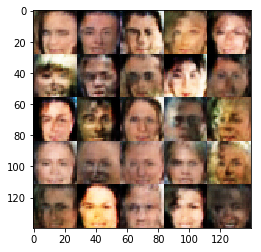

('Epoch 2/2 . step 4075...', 'Discriminator Loss: 1.4616...', 'Generator Loss: 0.7562')
('Epoch 2/2 . step 4100...', 'Discriminator Loss: 1.4106...', 'Generator Loss: 0.8579')
('Epoch 2/2 . step 4125...', 'Discriminator Loss: 1.3379...', 'Generator Loss: 0.7857')
('Epoch 2/2 . step 4150...', 'Discriminator Loss: 1.3988...', 'Generator Loss: 0.7814')
('Epoch 2/2 . step 4175...', 'Discriminator Loss: 1.3750...', 'Generator Loss: 0.8564')
('Epoch 2/2 . step 4200...', 'Discriminator Loss: 1.4018...', 'Generator Loss: 0.7403')


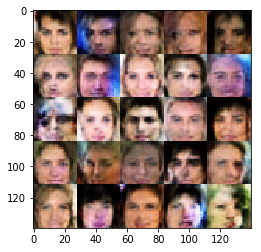

KeyboardInterrupt: 

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.